# Machine Learning Project 2022: Plankton

### Authors:
- Bram Fresen
- Bram Huis
- Max Burger
- Moos Middelkoop

For the Machine Learning Project to finish off the minor Artificial Intelligence, we chose to tackle the plankton problem, originally uploaded as the United States national data science bowl in december 2014. For this problem, the goal is to classify microscopic images of particles in water as one of 121 different classes of plankton. The dataset is 30.000 images large, with varying sizes. The dataset is also imbalanced.

In order to solve this problem we will make use of a Convolutional Neural Network using the tensorflow library.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import libraries

Firstly, we will import the needed libraries, and check if we are running on a GPU.

In [1]:
import tensorflow as tf 
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import math

from tensorflow.keras import layers, models, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

print(tf.config.list_physical_devices('GPU'))

[]


## Loading the training data and training labels

We use the cv2 library to load the training images (which are .jpg files), and turn them into arrays. This piece of code was found online:

https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
https://drive.google.com/file/d/1hAaPzDMVEZ8X1tfRS2ieFEqi0R7Ww7uL/view

### Training data

Training data is sorted into folders by class, this next piece of code reads in the training data, puts it in an array, and constructs an array for the classes by using the names of the folders. At the end, this array for the labels is turned into a one-hot matrix, so that tensorflow can work with it.

We also delete the unnecessary channels here already, all input images consist of 3 channels with exactly the same values, so we drop two of them in order to remove redundant data.

In [2]:
def read_data(folder):
    # Create empty lists for the not resized training data, the labels (not one hot encoded yet) and the class sizes
    train_data = []
    train_labels = []
    class_size_list = []
    offset = 0

    # Loop through the index (for the one hot matrix) and the categories
    for number, categories in enumerate(os.listdir(folder)):
        class_size = 0
        print(number)

        # If we come across a hidden folder (starting with ".") on mac os, we ignore it
        if categories[0] == ".":
            offset += 1
            continue

        # Loop through the images , add 1 to the class size, read the images in in and add them to a list, 
        # also add the index 'number' to a list for the one hot matrix
        for image in os.listdir(f'{folder}/{categories}'):
            class_size += 1
            train_labels.append(number - offset)
            img = cv2.imread(os.path.join(f'{folder}/{categories}', image))
            train_data.append(img[:, :, 0])
      
        # Append the size of the class to the class size list, in order to check the class sizes later, this way we
        # can ananlyze the degree of class imbalance
        class_size_list.append(class_size)

    # Create a one hot matrix from the train labels
    train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=121)
  
    return train_data, train_labels_one_hot, class_size_list

train_data, train_labels, class_size_list = read_data('data/train')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


# Resize input images

Because all images are differnt sizes, it is necessary to resize all input data to the same size, in order to make tensorflow be able to work with the data. The first cell below analyzes the sizes of the data, and the second cell actually resizes, based on this analysis. An essential element is explicitly adding a third dimension with a value of 1 to the images, otherwise tensorflow can't work with the data. Lastly, the data is converted into numpy arrays, so tensorflow will be able to work with them

Average dimensions: 66.66182093881856, 73.50728507383967
Lowest first dimension image (21, 51)
Lowest second dimension image (31, 51)


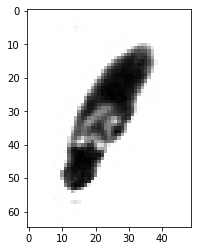

In [3]:
# Start with an infinitely large number
value_1 = math.inf
value_2 = math.inf
sum_1 = 0
sum_2 = 0
count = 0

# This checks for the lowest image size in the first and second dimension
for image in train_data:
    count+=1
    sum_1 += image.shape[0]
    sum_2 += image.shape[1]
    if image.shape[0] < value_1:
        
        value_1 = image.shape[0]
        hold_1 = image.shape
    if image.shape[1] < value_2:
        
        value_2 = image.shape[0]
        hold_2 = image.shape
        
sum_11 = sum_1 / count
sum_22 = sum_2 / count

print(f'Average dimensions: {sum_11}, {sum_22}')

plt.imshow(train_data[0], cmap = 'gray')

print(f'Lowest first dimension image {hold_1}')
print(f'Lowest second dimension image {hold_2}')

(27, 27, 1)


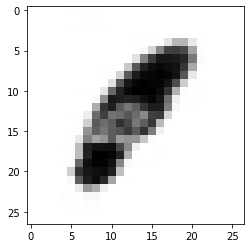

In [4]:
# Create an empty list for the training data
train_data_resized = []

# Loop through the images in the training data and resize them to the lowest shape in the dataset, 
# add a third dimension of 1 to the images and then append the image to the 'train_data_resized' list
for image in train_data:
    img = cv2.resize(image, dsize = (27, 27), interpolation = cv2.INTER_AREA)
    img = np.expand_dims(img, axis = 2)
    train_data_resized.append(img)

# Test if the image is resized and show the image
print(train_data_resized[0].shape)
plt.imshow(train_data_resized[0], cmap = 'gray')

#Split the data into 70% training and 30% validation
im_train, im_val, lab_train, lab_val = train_test_split(train_data_resized, train_labels, train_size=0.7, random_state=1265599650)

In [5]:
# Convert the data to numpy arrays, so tensorflow can use them
image_train = np.array(im_train)
label_train = np.array(lab_train)
image_val = np.array(im_val)
label_val = np.array(lab_val)

# Test if the shapes are correct
print(image_train.shape)
print(label_train.shape)
print(image_val.shape)
print(label_val.shape)

(21235, 27, 27, 1)
(21235, 121)
(9101, 27, 27, 1)
(9101, 121)


## Getting additional features out of the data

In [11]:
heights = []
widths = []
ratios = []

# height = index 0, width = index 1
for image in train_data:
    heights.append(image.shape[0])
    widths.append(image.shape[1])
    ratios.append(image.shape[0]/ image.shape[1])
    
print(heights[:10])
print(widths[:10])
print(ratios[:10])

[65, 55, 181, 102, 57, 63, 72, 65, 96, 65]
[49, 51, 163, 41, 32, 34, 50, 42, 54, 90]
[1.3265306122448979, 1.0784313725490196, 1.1104294478527608, 2.4878048780487805, 1.78125, 1.8529411764705883, 1.44, 1.5476190476190477, 1.7777777777777777, 0.7222222222222222]


## Convolutional network

We use the function 'train_and_evaluate' which, obviously, trains our model and then evaluates the trained model on the validation data. This function was reused from the CIFAR-assignment from module 6 of ML2.

Y_ints line: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [18]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)
    
    # used for k-fold
    y_ints = [y.argmax() for y in label_train]
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_ints), y = y_ints)
    
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")
    

## The actual model

We start with a very simple convolutional neural network, with 2 convolutional layers, both with pooling afterwards, and one dense layer. kernelsize, amount of filters, amount of nodes are specified in the code cell. This first version of the model gives us a validation accuracy of approximately 64%

In [19]:
first_layer_filters = 32
second_layer_filters = 64
third_layers_filters = 128

kernelsize = (3,3)
inputshape = (27,27, 1)
first_hidden_layer_nodes = 1024
second_hidden_layer_nodes = 512
output_nodes = 121
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
# optimizer = 'adam'

model_1 = models.Sequential()

model_1.add(layers.Conv2D(first_layer_filters, kernelsize, activation = 'relu', padding = 'same', input_shape = inputshape))
model_1.add(layers.MaxPooling2D((3, 3)))
model_1.add(layers.Dropout(0.2))

model_1.add(layers.Conv2D(second_layer_filters, kernelsize, activation = 'relu', padding = 'same', input_shape = inputshape))
model_1.add(layers.MaxPooling2D((3, 3)))
model_1.add(layers.BatchNormalization())

model_1.add(layers.Flatten())
model_1.add(layers.Dropout(0.35))
model_1.add(layers.Dense(first_hidden_layer_nodes, activation = 'relu'))
model_1.add(layers.Dropout(0.35))
model_1.add(layers.Dense(second_hidden_layer_nodes, activation = 'relu'))
model_1.add(layers.Dropout(0.35))
model_1.add(layers.Dense(output_nodes, activation = 'softmax'))

train_and_evaluate(model_1, image_train, label_train, image_val, label_val, epochs = 80)

Epoch 1/80
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
663/664 [============================>.] - ETA: 0s - loss: 4.3271 - accuracy: 0.0837WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x17094a200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

KeyboardInterrupt: 

In [ ]:
model_1.summary()